In [1]:
import re
import math

import pandas as pd 
import numpy as np 
import seaborn as sns 

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras import regularizers
from keras.activations import relu, sigmoid
from keras.optimizers import Adam

from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
pd.set_option('max_columns', None)
pd.set_option('display.float_format', str)
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9,5]
plt.rcParams["axes.edgecolor"] = "black"

# DNN Notebook

Build a custom DNN and train it to predict prices similar to done previously on the XGB notebook.

### Load data

In [2]:
df = pd.read_csv('datasets/train.csv')
df.head()

,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,num_venues,venue_senti,population_density,num_stations,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,0.4383081653381801,0.962355909433262,2700000,0.0845722904546434,0.4816494149414941,0.2,0.2,0.3333333333333333,0,0,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.438196481719345,0.9625700438791892,2850000,0.138763197586727,0.3239536453645364,0.4,0.2,0.3333333333333333,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4374371413216798,0.962334895669068,1150000,0.178517560870502,0.0512083708370837,0.6000000000000001,0.8,0.3333333333333333,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0.5050505050505052,0.7076226940480348,0.1798788778884154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4402993591219029,0.9658959433017896,2850000,0.1859513035983624,0.236053105310531,0.4,0.4000000000000001,0.0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1717171717171717,0.5917159763313613,0.0302598543085124,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4383267880012989,0.9623704305726386,1729200,0.0229476405946994,0.6860441044104411,0.0,0.0,0.3333333333333333,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test train split

In [3]:
# Target column
y = df['price']

# Feature columns and matrix
features = [col for col in df.columns if col not in ('price','price_per_sqft')]
X = df[features]

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.2)

# Features shape
n_features = train_X.shape[1]

In [4]:
# Just getting some info
print(f'Original dataset is {X.shape[0]} rows and {X.shape[1]} columns.')
print(f'Training dataset is {train_X.shape[0]} rows and {train_X.shape[1]} columns.')
print(f'Testing dataset is {val_X.shape[0]} rows and {val_X.shape[1]} columns.')

Original dataset is 1844 rows and 76 columns.
Training dataset is 1475 rows and 76 columns.
Testing dataset is 369 rows and 76 columns.


In [5]:
train_X.head(10)

,latitude,longitude,size_in_sqft,no_of_bedrooms,no_of_bathrooms,quality,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,num_venues,venue_senti,population_density,num_stations,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
686,0.4371403306290857,0.963435413028913,0.1101055806938159,0.4,0.4000000000000001,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0.0303030303030303,0.7381656804733732,0.1643664580487898,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,0.4371423028511404,0.9642292062260124,0.0760611937082525,0.2,0.2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.303030303030303,0.569383470127887,0.1092016387023415,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
785,0.4381576132369031,0.9625220124181744,0.1622495151906916,0.4,0.2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98989898989899,0.8520710059171606,0.039276146494397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1057,0.439731533703059,0.9648589035668396,0.1318681318681318,0.4,0.4000000000000001,0.3333333333333333,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1.0,0.9650295857988178,0.3315116564505499,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
794,0.4379068443299766,0.9625467960935526,0.3512174100409394,0.6000000000000001,0.8,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.8302958579881663,0.2960111604848664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
801,0.4394358400211862,0.9653160052979368,0.0214393449687567,0.2,0.0,0.0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0202020202020202,1.0,0.0138232533791627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1402,0.4371815902126028,0.9635884260444354,0.0647489765136823,0.4,0.4000000000000001,0.3333333333333333,1,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0.0303030303030303,0.7381656804733732,0.1643664580487898,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.4397187927995195,0.9646315744317674,0.0758457229045464,0.4,0.4000000000000001,0.0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.9650295857988178,0.3315116564505499,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1448,0.4397761268654475,0.9647167115926796,0.1717302305537599,0.4,0.2,0.3333333333333333,0,1,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1.0,0.9650295857988178,0.3315116564505499,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,0.4396456460505684,0.9648355336081554,0.1285283344106873,0.4,0.4000000000000001,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.9650295857988178,0.3315116564505499,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0

## Helper function to test model

In [6]:
def evaluate(y_val,y_pred):
    '''
    This function improves QOL for the programmer 
    by allowing to run tests fast without writing code over and over,
    to evaluate a models performance.
    
    '''
    y_pred = y_pred.ravel()
    te_y = np.array(y_val)
    
    # extract line of best fit statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(te_y,y_pred)
    
    # Print out results
    print(f'MAE = {mean_absolute_error(te_y, y_pred):.2f} AED')
    print(f'RMSE = {mean_squared_error(te_y, y_pred, squared = 0):.2f} AED')
    print(f'Normalized RMSE = {(mean_squared_error(te_y, y_pred, squared = 0))/(te_y.max() - te_y.min()):.2f} AED')
    print(f'Model accuracy (1 - MAPE) % = {(1 - mean_absolute_percentage_error(te_y, y_pred))*100:.2f} %')
    print(f'r = {r_value:.2f}, p = {p_value:.2f}, err = {std_err:.2f}')
    
    # Extract name from model __class__
    model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(model.__class__))[0]
  

    # plot A vs. P plot with regression line
    sns.regplot(x = te_y, y = y_pred, line_kws = {'label': f' y = {slope:.1f} x + {intercept:.1f}'})
    plt.legend()
    plt.title(f'{model_name}')
    plt.xlabel('Actual Price (AED)')
    plt.ylabel('Predicted Price (AED)')
    plt.show()


## Building the DNN

In [7]:
# Create the model
model = Sequential([

    Dense(n_features*3, activation='relu', kernel_regularizer = regularizers.l2(0.01), input_shape=(n_features,)),
        Dropout(0.3),
    Dense(n_features*2, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.3),
    Dense(n_features*1, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.3),
    Dense(n_features*0.5, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.3),
    Dense(n_features*0.25, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.3),
    Dense(n_features*0.125, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.3),
    Dense(1, activation = LeakyReLU(), kernel_regularizer = regularizers.l2(0.01)),

])



In [8]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'mse')

In [9]:
hist = model.fit(x = train_X,
                 y = train_y,
                 batch_size = 24,
                 epochs = 400,
                 validation_data = (val_X, val_y),
                verbose = 0
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 228)               17556     
_________________________________________________________________
dropout (Dropout)            (None, 228)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 152)               34808     
_________________________________________________________________
dropout_1 (Dropout)          (None, 152)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 76)                11628     
_________________________________________________________________
dropout_2 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 38)                2

## Evaluate model performance

### Plot Loss

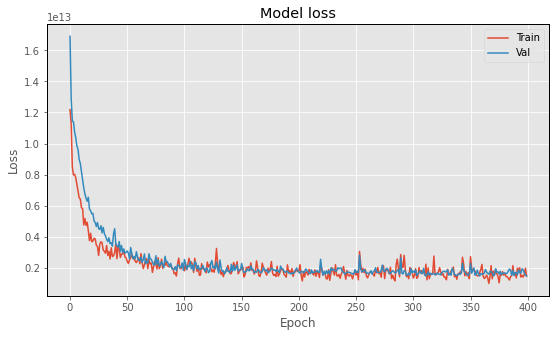

In [11]:
# Plot Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Plot accuracy

MAE = 602445.46 AED
RMSE = 1208251.06 AED
Normalized RMSE = 0.04 AED
Model accuracy (1 - MAPE) % = 73.34 %
r = 0.94, p = 0.00, err = 0.02


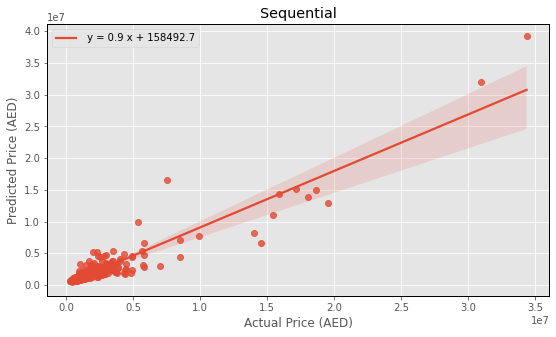

In [12]:
y_pred = model.predict(val_X)
evaluate(val_y,y_pred)